In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import lightgbm as lgb
import xgboost as xgb

In [2]:
dataset = pd.read_csv('2019-Oct.csv')

In [3]:
data = dataset

## Preprocessing - Category

In [4]:
data = dataset

data[['category1','category2','category3']] = data['category_code'].str.split('.', n=2, expand=True)
data = data.fillna('Unkown')

## Preprocessing - Datetime

In [5]:
data['event_time'] = pd.to_datetime(data['event_time'], utc=True)


data['event_time'] = data['event_time'].dt.tz_convert('Asia/Shanghai')
data['year'], data['month'], data['day'], data['dayofweek'], data['hour'] = data['event_time'].dt.year, data['event_time'].dt.month, data['event_time'].dt.day, data['event_time'].dt.dayofweek, data['event_time'].dt.hour

# Kmeans

In [6]:
df = data

In [7]:
label_encoder = LabelEncoder()
df['event_type_encoded'] = label_encoder.fit_transform(df['event_type'])

In [8]:
# Encoder data for category_code field by One-Hot Encoding
one_hot_encoded_df = pd.get_dummies(df['category_code'], prefix='category', dummy_na=True)
df = pd.concat([df, one_hot_encoded_df], axis=1)

In [9]:
# Group by user_id for user-level aggregation
user_features = df.groupby('user_id').agg(
    event_time=('event_time', 'max'),             # Last interaction time
    activity_frequency=('event_type', 'count'),  # Frequency of activity
    unique_products=('product_id', 'nunique'),   # Number of unique products
    unique_brands=('brand', 'nunique'),          # Number of unique brands
    average_spend=('price', 'mean'),             # Average spending
    most_common_category=('category_code', lambda x: x.mode()[0] if not x.mode().empty else None),  # Most common category
).reset_index()

# Calculate recency
current_time = df['event_time'].max()
user_features['recency'] = (current_time - user_features['event_time']).dt.total_seconds()

# Aggregate event_type_encoded counts (if needed for deeper analysis)
event_counts = df.groupby(['user_id', 'event_type_encoded']).size().unstack(fill_value=0).reset_index()
event_counts.columns.name = None  # Remove the name from columns

# Merge event_type_encoded counts back into user_features
user_data = pd.merge(user_features, event_counts, on='user_id', how='left')

# Display final user-level dataset
user_data

,user_id,event_time,activity_frequency,unique_products,unique_brands,average_spend,most_common_category,recency,0,1,2
0,33869381,2019-10-24 04:04:08+08:00,1,1,1,769.650000,kids.carriage,705351.0,0,0,1
1,64078358,2019-10-13 08:13:46+08:00,1,1,1,0.000000,Unkown,1640773.0,0,0,1
2,183503497,2019-10-03 05:43:00+08:00,1,1,1,15.770000,Unkown,2513819.0,0,0,1
3,184265397,2019-10-16 01:19:28+08:00,6,3,2,111.706667,furniture.living_room.chair,1406431.0,0,0,6
4,195082191,2019-10-10 11:35:36+08:00,1,1,1,161.880000,electronics.audio.headphone,1887863.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
3022285,566280663,2019-11-01 07:58:42+08:00,2,1,1,1671.660000,electronics.smartphone,77.0,0,0,2
3022286,566280676,2019-11-01 07:58:39+08:00,1,1,1,176.040000,furniture.bedroom.bed,80.0,0,0,1
3022287,566280697,2019-11-01 07:58:56+08:00,1,1,1,434.500000,electronics.camera.video,63.0,0,0,1
3022288,566280780,2019-11-01 07:59:02+08:00,1,1,1,874.930000,Unkown,57.0,0,0,1


In [10]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Define the final features to scale (including one-hot encoded columns)
features_to_scale = [
    'activity_frequency',  # Total events
    'unique_products',     # Number of unique products
    'unique_brands',       # Number of unique brands
    'average_spend',       # Average spend
    'recency',             # Time since last interaction
]

# Drop rows with missing values in the selected features
user_features_cleaned = user_features.dropna(subset=features_to_scale)

# Standardize the selected features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(user_features_cleaned[features_to_scale])

# Verify the shape and sample of the scaled data
print(f"Scaled data shape: {scaled_data.shape}")

Scaled data shape: (3022290, 5)


In [11]:
from sklearn.cluster import KMeans
# Select the optimal number of clusters, e.g., k = 5 from the Elbow graph
optimal_k = 5

# Apply K-means with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
user_data['cluster'] = kmeans.fit_predict(scaled_data)

# Display the user data with assigned cluster labels
user_data

,user_id,event_time,activity_frequency,unique_products,unique_brands,average_spend,most_common_category,recency,0,1,2,cluster
0,33869381,2019-10-24 04:04:08+08:00,1,1,1,769.650000,kids.carriage,705351.0,0,0,1,3
1,64078358,2019-10-13 08:13:46+08:00,1,1,1,0.000000,Unkown,1640773.0,0,0,1,2
2,183503497,2019-10-03 05:43:00+08:00,1,1,1,15.770000,Unkown,2513819.0,0,0,1,2
3,184265397,2019-10-16 01:19:28+08:00,6,3,2,111.706667,furniture.living_room.chair,1406431.0,0,0,6,2
4,195082191,2019-10-10 11:35:36+08:00,1,1,1,161.880000,electronics.audio.headphone,1887863.0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...
3022285,566280663,2019-11-01 07:58:42+08:00,2,1,1,1671.660000,electronics.smartphone,77.0,0,0,2,3
3022286,566280676,2019-11-01 07:58:39+08:00,1,1,1,176.040000,furniture.bedroom.bed,80.0,0,0,1,0
3022287,566280697,2019-11-01 07:58:56+08:00,1,1,1,434.500000,electronics.camera.video,63.0,0,0,1,0
3022288,566280780,2019-11-01 07:59:02+08:00,1,1,1,874.930000,Unkown,57.0,0,0,1,3


In [12]:
cluster_counts = user_data['cluster'].value_counts()
cluster_counts

cluster
0    1377396
2    1006370
3     348436
1     266094
4      23994
Name: count, dtype: int64

# Build model for price sensitive users

In [13]:
target_users = user_data[user_data['cluster'] == 0]

In [14]:
target_users = target_users['user_id'].tolist()

In [15]:
filtered_data = data[data['user_id'].isin(target_users)]

In [16]:
filtered_data

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,category1,category2,category3,year,month,day,dayofweek,hour,event_type_encoded
3,2019-10-01 08:00:01+08:00,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713,computers,notebook,Unkown,2019,10,1,1,8,2
8,2019-10-01 08:00:10+08:00,view,28719074,2053013565480109009,apparel.shoes.keds,baden,102.71,520571932,ac1cd4e5-a3ce-4224-a2d7-ff660a105880,apparel,shoes,keds,2019,10,1,1,8,2
9,2019-10-01 08:00:11+08:00,view,1004545,2053013555631882655,electronics.smartphone,huawei,566.01,537918940,406c46ed-90a4-4787-a43b-59a410c1a5fb,electronics,smartphone,Unkown,2019,10,1,1,8,2
10,2019-10-01 08:00:11+08:00,view,2900536,2053013554776244595,appliances.kitchen.microwave,elenberg,51.46,555158050,b5bdd0b3-4ca2-4c55-939e-9ce44bb50abd,appliances,kitchen,microwave,2019,10,1,1,8,2
17,2019-10-01 08:00:18+08:00,view,10900029,2053013555069845885,appliances.kitchen.mixer,bosch,58.95,519528062,901b9e3c-3f8f-4147-a442-c25d5c5ed332,appliances,kitchen,mixer,2019,10,1,1,8,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42448755,2019-11-01 07:59:58+08:00,view,12800151,2053013552788144369,Unkown,sony,8.49,544578298,fb46b2fb-493b-477c-8d18-ea1c24c04020,Unkown,Unkown,Unkown,2019,11,1,4,7,2
42448757,2019-11-01 07:59:58+08:00,view,1004870,2053013555631882655,electronics.smartphone,samsung,275.25,518956209,6764041a-9285-4869-8a32-a79adf31d212,electronics,smartphone,Unkown,2019,11,1,4,7,2
42448761,2019-11-01 07:59:58+08:00,view,5701038,2053013553970938175,auto.accessories.player,kenwood,128.70,566280422,05b6c62b-992f-4e8e-91f7-961bcb4719cd,auto,accessories,player,2019,11,1,4,7,2
42448762,2019-11-01 07:59:59+08:00,view,21407424,2053013561579406073,electronics.clocks,tissot,689.85,513118352,4c14bf2a-2820-4504-929d-046356a5a204,electronics,clocks,Unkown,2019,11,1,4,7,2


## More EDA related to purchase rate

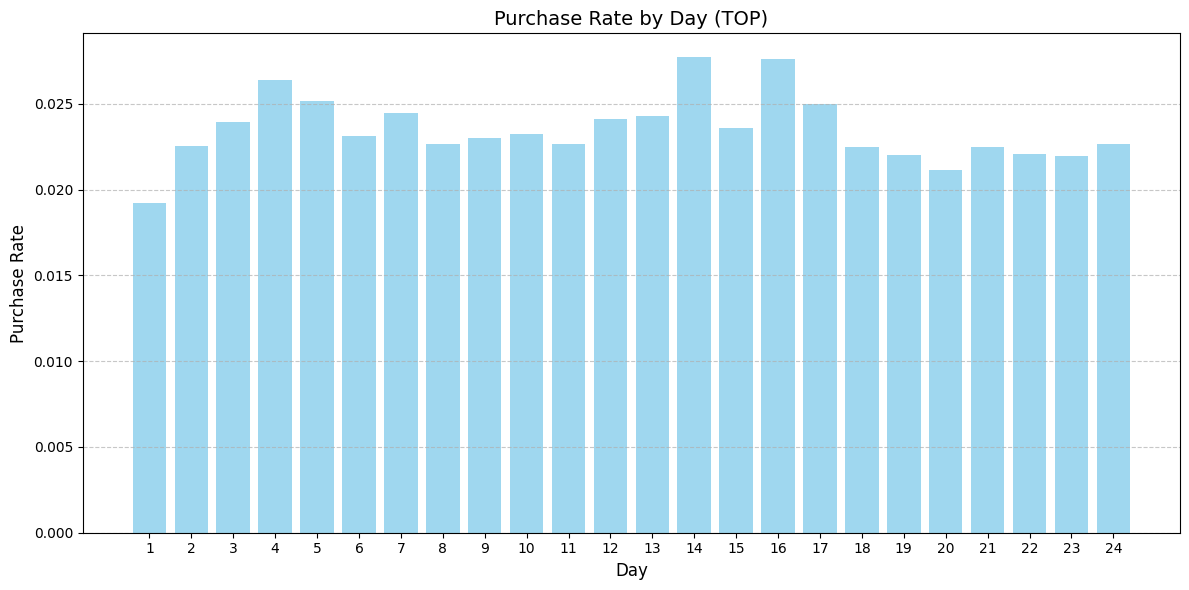

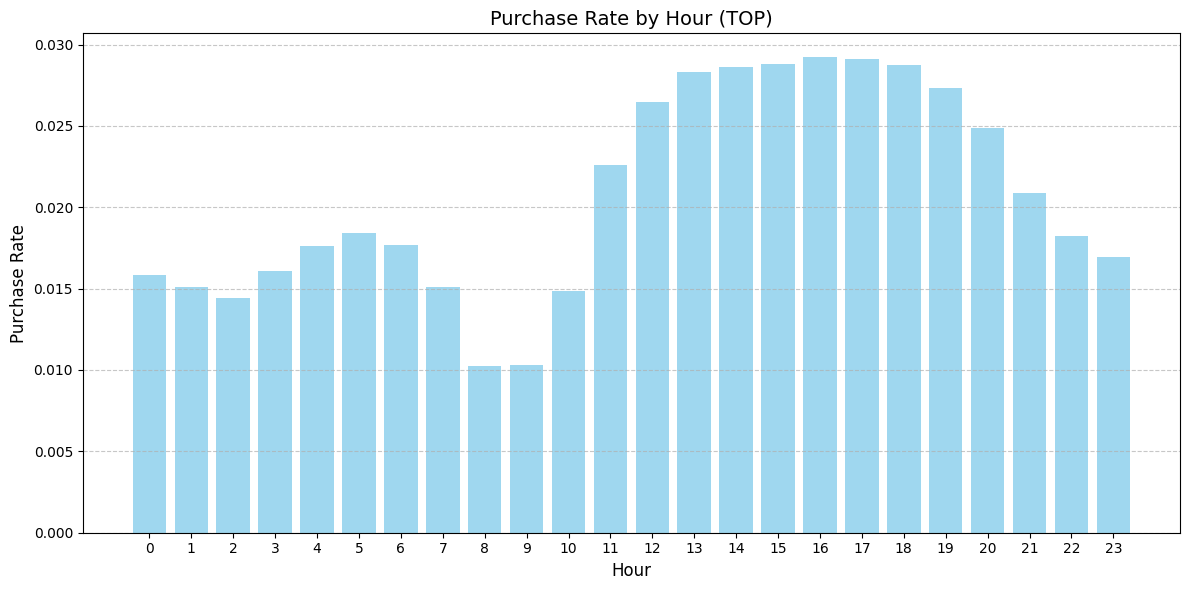

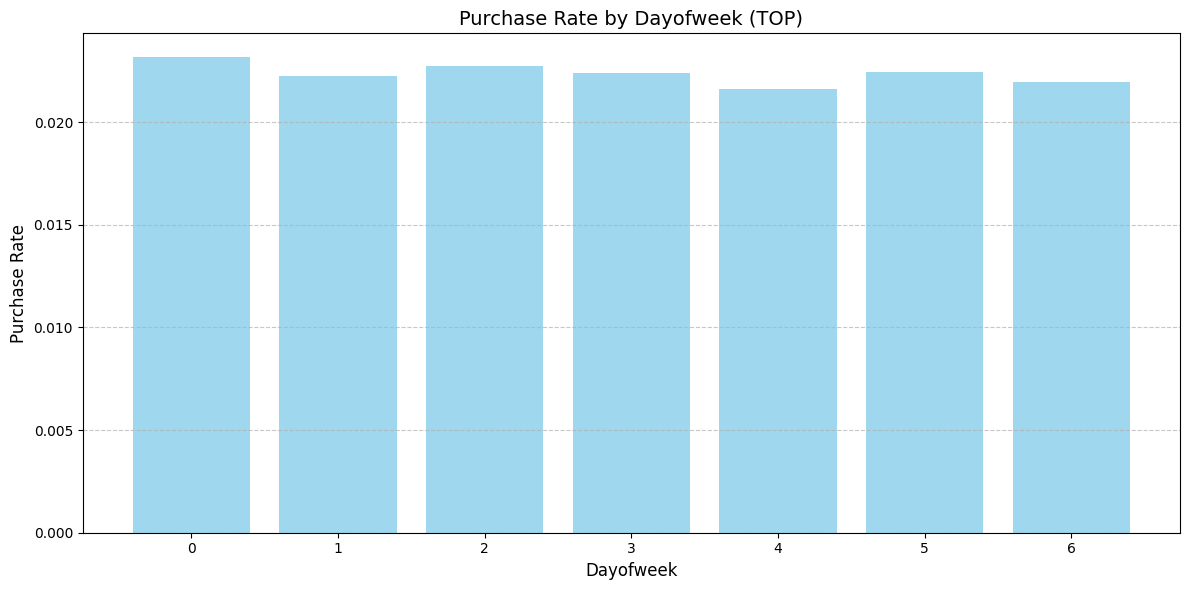

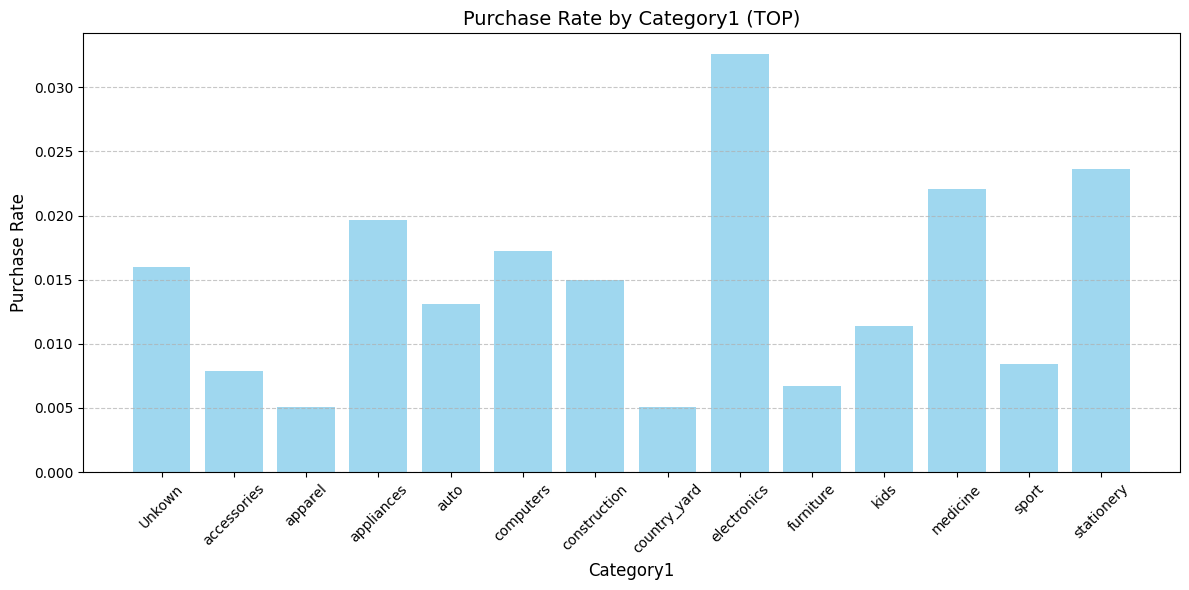

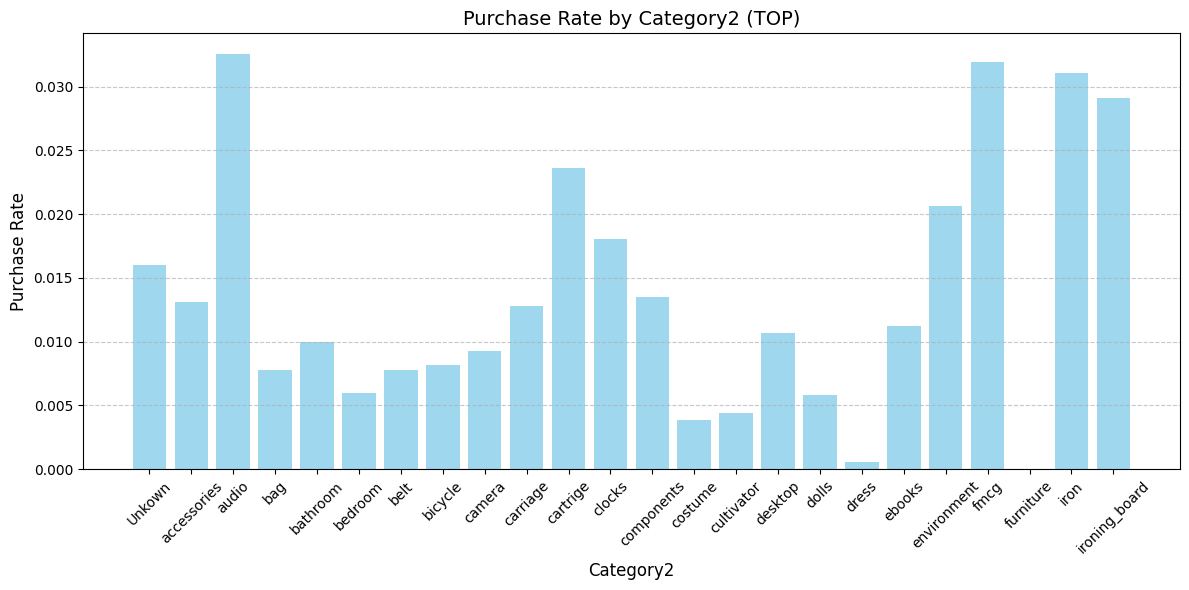

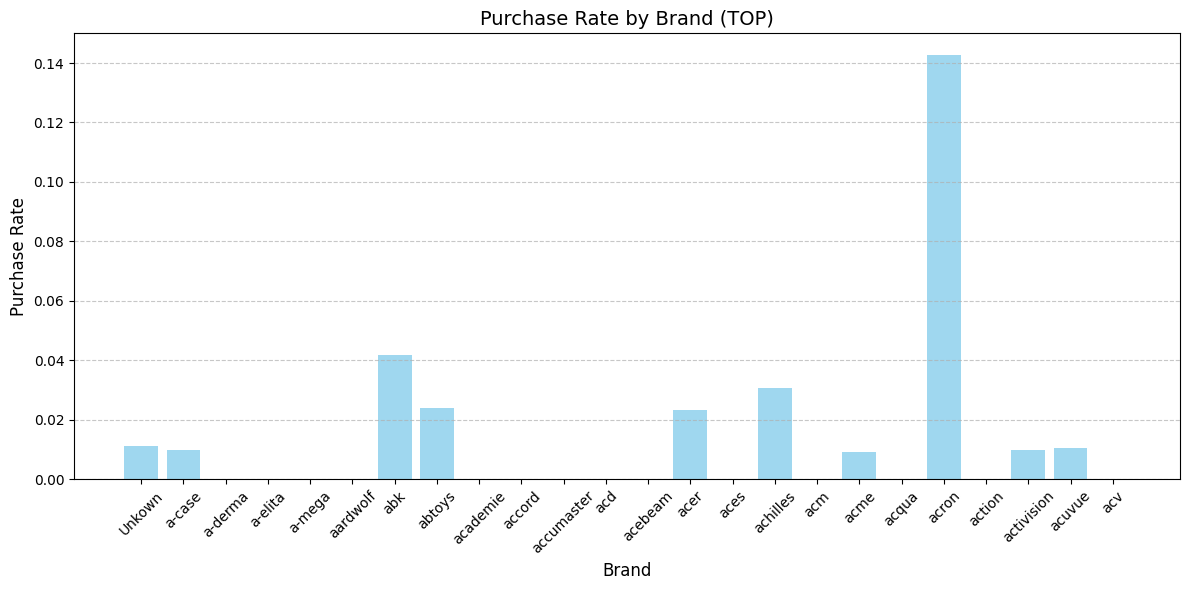

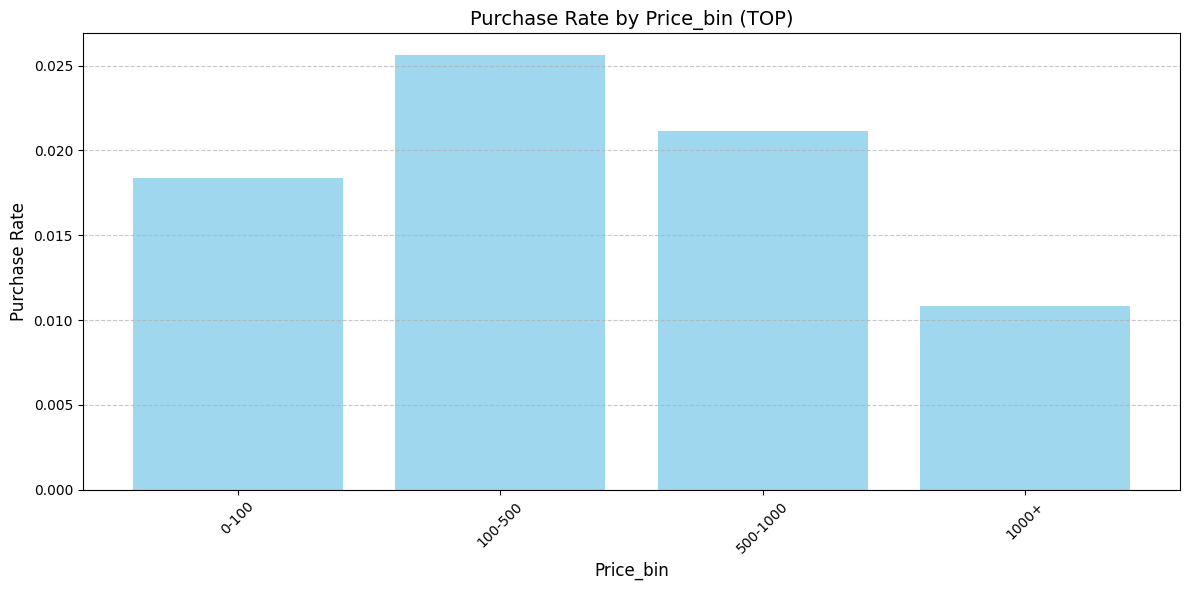

In [97]:
data['purchase_flag'] = (data['event_type'] == 'purchase').astype(int)
data['view_flag'] = (data['event_type'] == 'view').astype(int)

# Add a price_bin column to categorize prices into 4 intervals
price_bins = [0, 100, 500, 1000, float('inf')]
price_labels = ['0-100', '100-500', '500-1000', '1000+']
data['price_bin'] = pd.cut(data['price'], bins=price_bins, labels=price_labels)

dimensions = ['day', 'hour', 'dayofweek', 'category1', 'category2', 'brand', 'price_bin']

# Calculate purchase rate for each dimension
purchase_rate_by_dimension = {}
for dim in dimensions:
    grouped = data.groupby(dim).agg(
        purchase=('purchase_flag', 'sum'),
        view=('view_flag', 'sum')
    ).reset_index()
    grouped['purchase_rate'] = grouped['purchase'] / grouped['view']
    purchase_rate_by_dimension[dim] = grouped

# Define the maximum number of categories to display to avoid chart clutter
MAX_CATEGORIES = 24

# Plot purchase rate bar charts for each dimension
for dim, grouped_filtered_data in purchase_rate_by_dimension.items():
    # Select the top MAX_CATEGORIES without sorting
    grouped_filtered_data_limited = grouped_filtered_data.head(MAX_CATEGORIES)
    
    # Plot the bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(grouped_filtered_data_limited[dim].astype(str), grouped_filtered_data_limited['purchase_rate'], color='skyblue', alpha=0.8)
    
    # Set chart title and labels
    plt.xlabel(dim.capitalize(), fontsize=12)
    plt.ylabel('Purchase Rate', fontsize=12)
    plt.title(f'Purchase Rate by {dim.capitalize()} (TOP)', fontsize=14)
    plt.xticks(fontsize=10, rotation=45 if dim in ['category1', 'category2', 'brand', 'price_bin'] else 0)
    plt.yticks(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Adjust layout and display the chart
    plt.tight_layout()
    plt.show()


## Feature engineering

In [19]:
import numpy as np
import pandas as pd
from collections import deque

# Sort by user and event time
filtered_data = filtered_data.sort_values(['user_id', 'event_time']).reset_index(drop=True)

# Extract user group indices
user_indices = filtered_data.groupby('user_id').indices

# Initialize storage for results
recent_info = {
    'last_purchase_product_id': [None] * len(filtered_data),
    'last_cart_product_id': [None] * len(filtered_data),
    'last_view_product_ids': [None] * len(filtered_data),
    
    'last_purchase_category_id': [None] * len(filtered_data),
    'last_cart_category_id': [None] * len(filtered_data),
    'last_view_category_ids': [None] * len(filtered_data),
    
    'recent_3_same_brand_ratio': [None] * len(filtered_data),
    'recent_3_same_category_id_ratio': [None] * len(filtered_data),
    
    'time_since_last_purchase': [None] * len(filtered_data),
    'last_purchase_price': [None] * len(filtered_data),
}

# Define function to calculate the ratio of recent items
def calculate_ratio(recent_items, current_value):
    return np.sum(recent_items == current_value) / len(recent_items) if len(recent_items) > 0 else 0

count = 0
# Iterate over each user and update recent behaviors
for user, user_idx in user_indices.items():
    count += 1
    print(count)
    # Extract the current user's subset and reset index
    user_data = filtered_data.iloc[user_idx].reset_index(drop=True)

    # Extract current user's columns as NumPy arrays
    event_times = user_data['event_time'].to_numpy()
    brand_values = user_data['brand'].to_numpy()
    category_id_values = user_data['category_id'].to_numpy()
    price_values = user_data['price'].to_numpy()  
    product_id_values = user_data['product_id'].to_numpy()

    # Initialize recent behaviors
    temp_purchase, temp_cart = None, None
    temp_views = deque(maxlen=5)
    temp_views_category_id = deque(maxlen=5)

    for idx, row in user_data.iterrows():
        global_idx = user_idx[idx]  # Directly get the global index

        # Current row attribute values
        current_event_time = row.event_time
        current_brand = row.brand
        current_category_id = row.category_id

        # Last purchase
        if temp_purchase is not None:
            recent_info['last_purchase_product_id'][global_idx] = product_id_values[temp_purchase]
            recent_info['last_purchase_category_id'][global_idx] = category_id_values[temp_purchase]
            recent_info['last_purchase_price'][global_idx] = price_values[temp_purchase]
        else:
            recent_info['last_purchase_product_id'][global_idx] = None
            recent_info['last_purchase_category_id'][global_idx] = None
            recent_info['last_purchase_price'][global_idx] = None

        # Last cart
        if temp_cart is not None:
            recent_info['last_cart_product_id'][global_idx] = product_id_values[temp_cart]
            recent_info['last_cart_category_id'][global_idx] = category_id_values[temp_cart]
        else:
            recent_info['last_cart_product_id'][global_idx] = None
            recent_info['last_cart_category_id'][global_idx] = None

        # Recent views product_ids and category_ids
        recent_info['last_view_product_ids'][global_idx] = [product_id_values[i] for i in temp_views]
        recent_info['last_view_category_ids'][global_idx] = [category_id_values[i] for i in temp_views_category_id]

        # Recent 3 views with same brand and category_id ratio
        if temp_views_category_id:
            recent_3_items = list(temp_views_category_id)[:3]
            recent_3_brands = brand_values[recent_3_items]
            recent_3_category_ids = category_id_values[recent_3_items]

            recent_info['recent_3_same_brand_ratio'][global_idx] = calculate_ratio(
                recent_3_brands, current_brand
            )
            recent_info['recent_3_same_category_id_ratio'][global_idx] = calculate_ratio(
                recent_3_category_ids, current_category_id
            )

        # Last purchase time
        if temp_purchase is not None:
            last_purchase_time = event_times[temp_purchase]
            recent_info['time_since_last_purchase'][global_idx] = (
                current_event_time - last_purchase_time
            ).total_seconds()

        # Update sliding window
        if row.event_type == "purchase":
            temp_purchase = idx
        elif row.event_type == "cart":
            temp_cart = idx
        elif row.event_type == "view":
            temp_views.appendleft(idx)
            temp_views_category_id.appendleft(idx)

# Merge the results into the original data
recent_info_df = pd.DataFrame(recent_info)
filtered_data = pd.concat([filtered_data, recent_info_df], axis=1)

# Expand the last viewed product and category IDs
filtered_data[[f'last_view_product_id_{i+1}' for i in range(5)]] = pd.DataFrame(
    filtered_data['last_view_product_ids'].tolist(), index=filtered_data.index
)
filtered_data[[f'last_view_category_id_{i+1}' for i in range(5)]] = pd.DataFrame(
    filtered_data['last_view_category_ids'].tolist(), index=filtered_data.index
)

# Drop intermediate columns
filtered_data.drop(columns=['last_view_product_ids', 'last_view_category_ids'], inplace=True)


1377396


In [20]:
# Feature Interaction
filtered_data['dayofweek_hour'] = filtered_data['dayofweek'].astype(str) + '_' + data['hour'].astype(str)

In [21]:
filtered_data.columns

Index(['event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session',
       'category1', 'category2', 'category3', 'year', 'month', 'day',
       'dayofweek', 'hour', 'event_type_encoded', 'last_purchase_product_id',
       'last_cart_product_id', 'last_purchase_category_id',
       'last_cart_category_id', 'recent_3_same_brand_ratio',
       'recent_3_same_category_id_ratio', 'time_since_last_purchase',
       'last_purchase_price', 'last_view_product_id_1',
       'last_view_product_id_2', 'last_view_product_id_3',
       'last_view_product_id_4', 'last_view_product_id_5',
       'last_view_category_id_1', 'last_view_category_id_2',
       'last_view_category_id_3', 'last_view_category_id_4',
       'last_view_category_id_5', 'dayofweek_hour'],
      dtype='object')

# LightGBM Model

In [48]:
# 1. Build targe 
filtered_data['target'] = (filtered_data['event_type'] == 'purchase').astype(int)
final_data = filtered_data

# 2. Chose final features
feature_columns = ['price', 'category_id', 'brand', 'category1', 'category2', 'category3', 'hour',
                   'last_purchase_product_id', 'last_cart_product_id',
                   'last_purchase_category_id', 'last_cart_category_id',
                   'recent_3_same_brand_ratio', 'recent_3_same_category_id_ratio',
                   'time_since_last_purchase', 'last_purchase_price',
                   'last_view_product_id_1', 'last_view_product_id_2', 'last_view_product_id_3', 'last_view_product_id_4', 'last_view_product_id_5',
                   'last_view_category_id_1','last_view_category_id_2', 'last_view_category_id_3','last_view_category_id_4', 'last_view_category_id_5',
                   'dayofweek_hour','user_id']

catfeat = ['category_id', 'brand', 'category1', 'category2', 'category3',
                   'last_purchase_product_id', 'last_cart_product_id',
                   'last_purchase_category_id', 'last_cart_category_id',
                   'last_view_product_id_1', 'last_view_product_id_2', 'last_view_product_id_3', 'last_view_product_id_4', 'last_view_product_id_5',
                   'last_view_category_id_1','last_view_category_id_2', 'last_view_category_id_3','last_view_category_id_4', 'last_view_category_id_5',
                   'dayofweek_hour','user_id']

# Sort by time
final_data = final_data.sort_values(by='event_time')

# Define last 7 days data as test data (avoid data leak)
test_start_time = final_data['event_time'].max() - pd.Timedelta(days=7)

train_data_df = final_data[final_data['event_time'] < test_start_time]
test_data_df = final_data[final_data['event_time'] >= test_start_time]

# 3. Data split
X_train = train_data_df[feature_columns]
y_train = train_data_df['target']
X_valid = test_data_df[feature_columns]
y_valid = test_data_df['target']

# 4. Deal with categorical data
for col in catfeat:
    X_train[col] = X_train[col].astype('category')
    X_valid[col] = X_valid[col].astype('category')

# 5. Build LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=catfeat)
valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)


# 5. Set parameters
params = {
    'objective': 'binary',
    'metric': 'auc',
    'num_leaves': 256,
    'max_depth': 12,
    'learning_rate': 0.05,
    'colsample_bytree': 0.8,
    'bagging_fraction': 0.8,
    'min_child_samples': 40,
    'lambda_l1': 1,
    'n_jobs': -1,
    'seed': 1000,
}

# 6. Model traning
gbm = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, valid_data],
    valid_names=['train', 'valid'],
    num_boost_round=500,
    callbacks=[
        lgb.early_stopping(stopping_rounds=50), # early stop 50 rounds
        lgb.log_evaluation(period=50)  # print result every 50 rounds
    ]
)

# 7. Predict
preds = gbm.predict(X_valid, num_iteration=gbm.best_iteration)

# 8. Evaluation
y_pred = (preds >= 0.2).astype(int)
auc_score = roc_auc_score(y_valid, preds)
accuracy = accuracy_score(y_valid, y_pred)

print(f"Final AUC: {auc_score:.4f}, Accuracy: {accuracy:.4f}")


[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 176213, number of negative: 7862060
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.203530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 51618
[LightGBM] [Info] Number of data points in the train set: 8038273, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.021922 -> initscore=-3.798110
[LightGBM] [Info] Start training from score -3.798110
Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.926895	valid's auc: 0.909203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	train's auc: 0.938925	valid's auc: 0.911201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

## Visualization

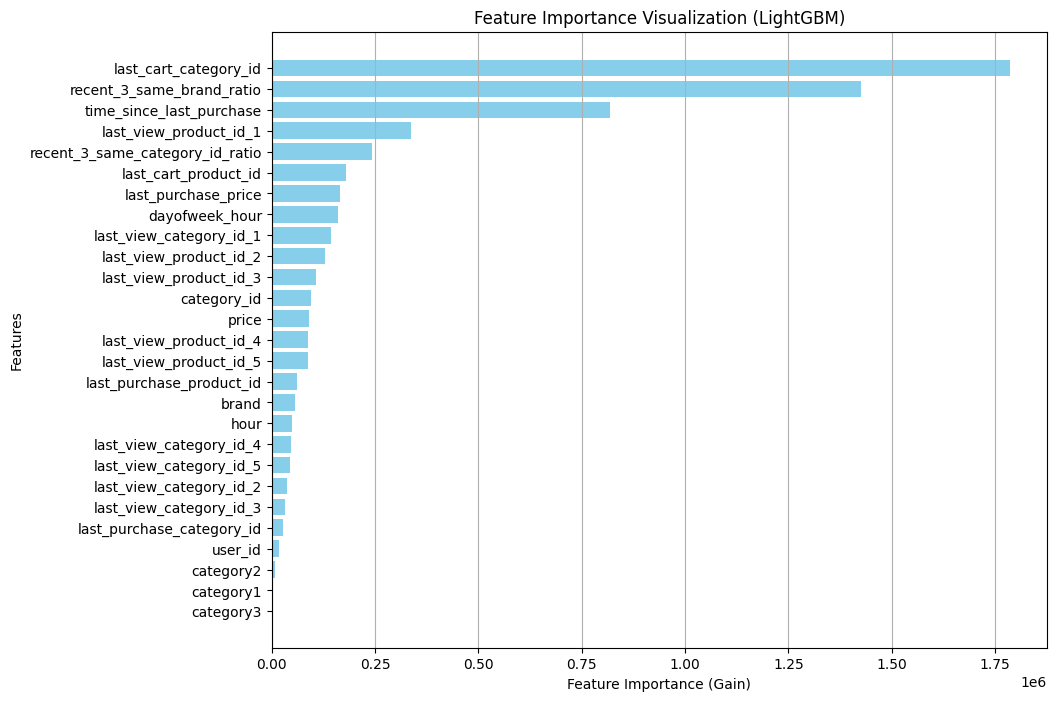

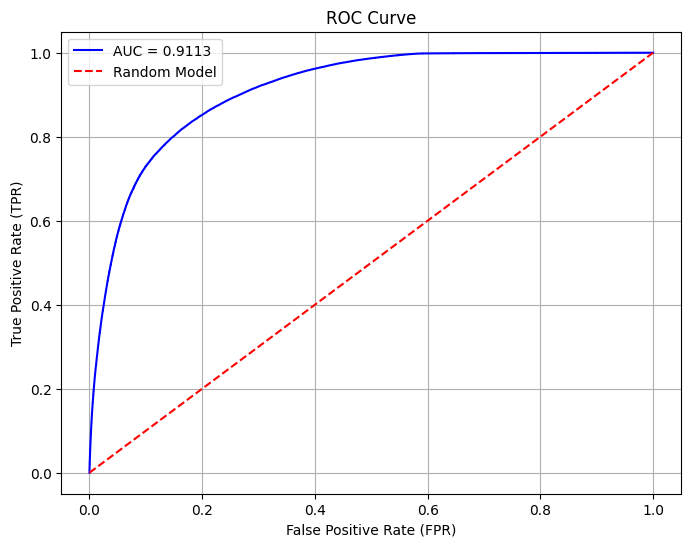

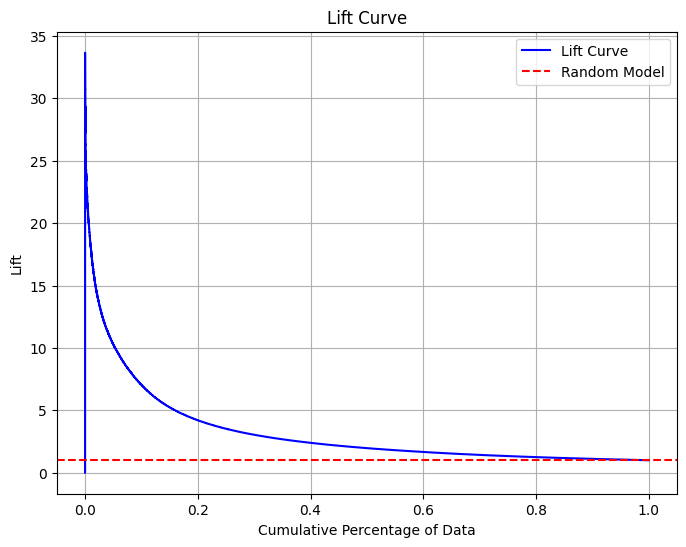

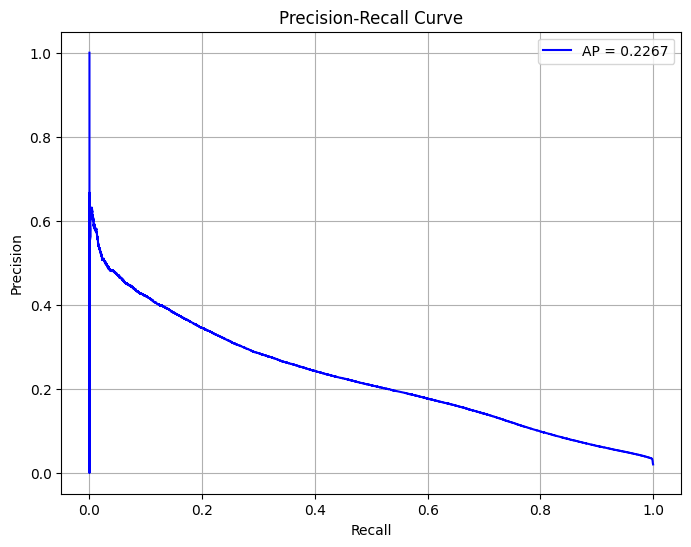

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

features = gbm.feature_name()  

feature_importance = pd.DataFrame({
    "Feature": features,
    "Importance": gbm.feature_importance(importance_type='gain')  
})

feature_importance = feature_importance.sort_values(by="Importance", ascending=False)


plt.figure(figsize=(10, 8))
plt.barh(feature_importance["Feature"], feature_importance["Importance"], color='skyblue')
plt.xlabel("Feature Importance (Gain)")
plt.ylabel("Features")
plt.title("Feature Importance Visualization (LightGBM)")
plt.gca().invert_yaxis()  
plt.grid(axis='x')
plt.show()


y_pred_proba = gbm.predict(X_valid)

# AUC 
fpr, tpr, roc_thresholds = roc_curve(y_valid, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}', color='b')
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Model')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

# Lift
data = pd.DataFrame({'y_true': y_valid, 'y_score': y_pred_proba})
data = data.sort_values('y_score', ascending=False).reset_index(drop=True)
data['cumulative_positives'] = data['y_true'].cumsum()
data['cumulative_percentage'] = (data.index + 1) / len(data)
data['lift'] = data['cumulative_positives'] / (data['cumulative_percentage'] * data['y_true'].sum())

plt.figure(figsize=(8, 6))
plt.plot(data['cumulative_percentage'], data['lift'], label='Lift Curve', color='b')
plt.axhline(1, color='r', linestyle='--', label='Random Model')
plt.xlabel('Cumulative Percentage of Data')
plt.ylabel('Lift')
plt.title('Lift Curve')
plt.legend()
plt.grid()
plt.show()

# PR 
precision, recall, pr_thresholds = precision_recall_curve(y_valid, y_pred_proba)
average_precision = average_precision_score(y_valid, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AP = {average_precision:.4f}', color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()


# XGBoost

In [46]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_curve, average_precision_score
import xgboost as xgb

# 1. Build target
filtered_data['target'] = (filtered_data['event_type'] == 'purchase').astype(int)
final_data = filtered_data

# 2. Chose final features
feature_columns = ['price', 'category_id', 'brand', 'category1', 'category2', 'category3', 'hour',
                   'last_purchase_product_id', 'last_cart_product_id',
                   'last_purchase_category_id', 'last_cart_category_id',
                   'recent_3_same_brand_ratio', 'recent_3_same_category_id_ratio',
                   'time_since_last_purchase', 'last_purchase_price',
                   'last_view_product_id_1', 'last_view_product_id_2', 'last_view_product_id_3', 'last_view_product_id_4', 'last_view_product_id_5',
                   'last_view_category_id_1','last_view_category_id_2', 'last_view_category_id_3','last_view_category_id_4', 'last_view_category_id_5',
                   'dayofweek_hour','user_id']

catfeat = ['category_id', 'brand', 'category1', 'category2', 'category3',
           'last_purchase_product_id', 'last_cart_product_id',
           'last_purchase_category_id', 'last_cart_category_id',
           'last_view_product_id_1', 'last_view_product_id_2', 'last_view_product_id_3', 'last_view_product_id_4', 'last_view_product_id_5',
           'last_view_category_id_1','last_view_category_id_2', 'last_view_category_id_3','last_view_category_id_4', 'last_view_category_id_5',
           'dayofweek_hour','user_id']

# Sort by time
final_data = final_data.sort_values(by='event_time')

# Define last 4 days data as test data (avoid data leak)
test_start_time = final_data['event_time'].max() - pd.Timedelta(days=7)

train_data_df = final_data[final_data['event_time'] < test_start_time]
test_data_df = final_data[final_data['event_time'] >= test_start_time]

# 3. Data split
X_train = train_data_df[feature_columns]
y_train = train_data_df['target']
X_valid = test_data_df[feature_columns]
y_valid = test_data_df['target']

# 4. Deal with categorical data
# XGBoost requires encoding categorical features manually (e.g., Label Encoding or One-Hot Encoding)
for col in catfeat:
    X_train[col] = X_train[col].astype('category').cat.codes
    X_valid[col] = X_valid[col].astype('category').cat.codes

# 5. Build DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

# 6. Set parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 12,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 40,
    'seed': 1000,
    'n_jobs': -1,
}

# 7. Model training
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

xgboost = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=watchlist,
    early_stopping_rounds=50,
    verbose_eval=50
)

# 8. Predict
preds = xgboost.predict(dvalid)

# 9. Evaluation
y_pred = (preds >= 0.2).astype(int)
auc_score = roc_auc_score(y_valid, preds)
accuracy = accuracy_score(y_valid, y_pred)

print(f"Final AUC: {auc_score:.4f}, Accuracy: {accuracy:.4f}")


[0]	train-auc:0.89940	valid-auc:0.89350
[50]	train-auc:0.91005	valid-auc:0.90383
[100]	train-auc:0.91438	valid-auc:0.90620
[150]	train-auc:0.91764	valid-auc:0.90747
[200]	train-auc:0.92036	valid-auc:0.90789
[239]	train-auc:0.92260	valid-auc:0.90776
Final AUC: 0.9078, Accuracy: 0.9773


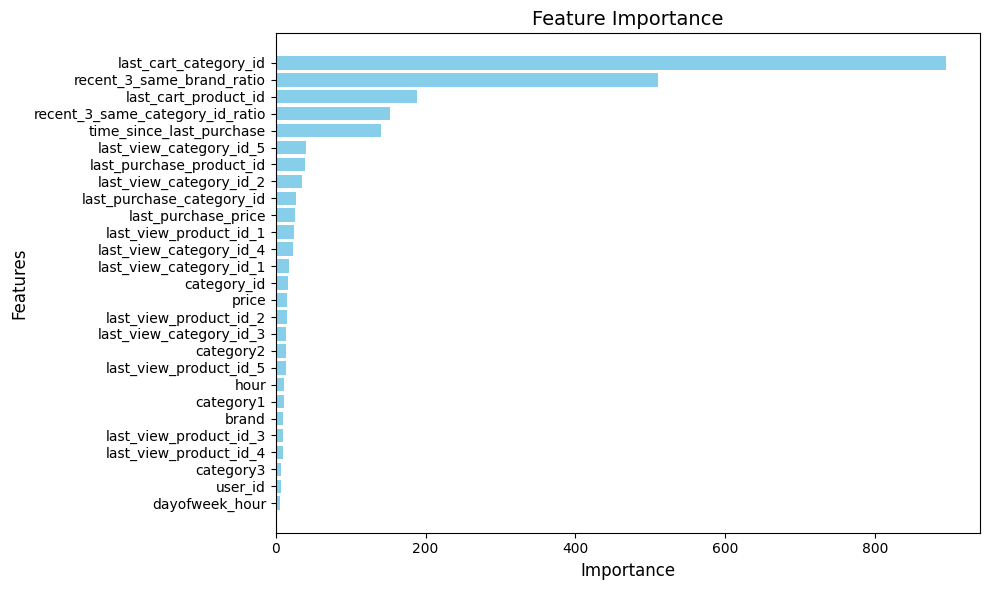

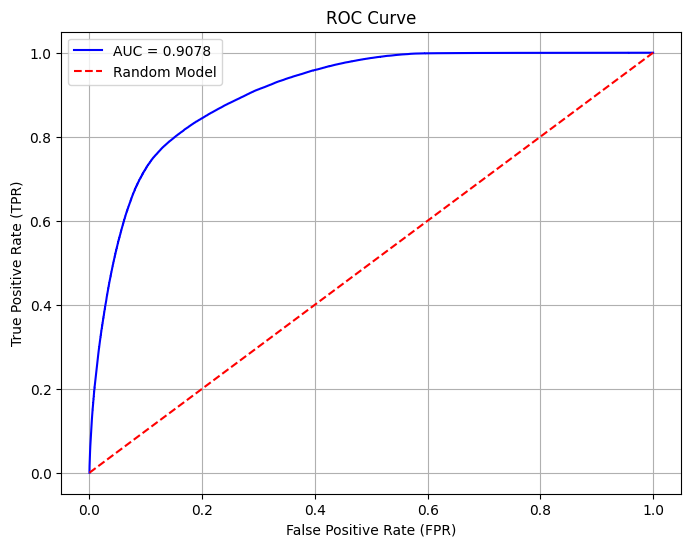

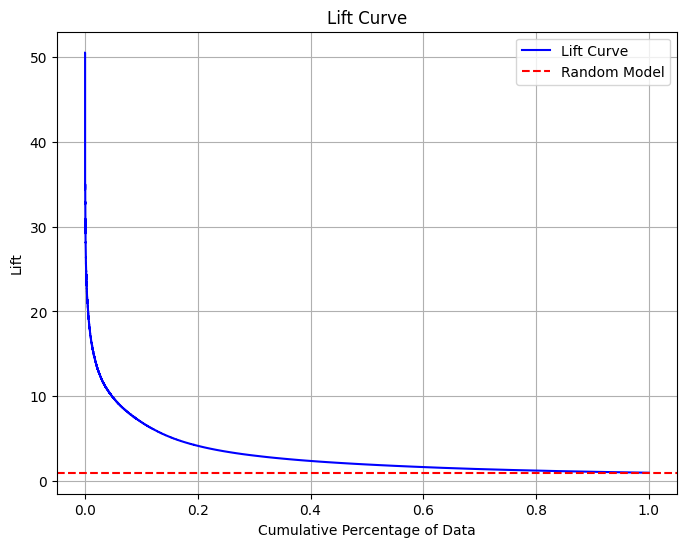

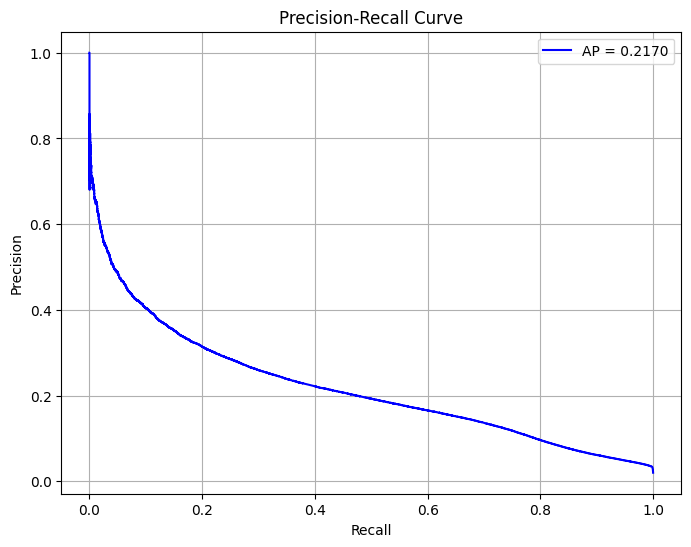

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

import matplotlib.pyplot as plt
import pandas as pd

importance = xgboost.get_score(importance_type='gain')
feature_importance = pd.DataFrame(list(importance.items()), columns=['feature_name', 'importance']).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature_name'], feature_importance['importance'], color='skyblue')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importance', fontsize=14)
plt.gca().invert_yaxis()  
plt.tight_layout()
plt.show()


y_pred_proba = xgboost.predict(dvalid)

# AUC 
fpr, tpr, roc_thresholds = roc_curve(y_valid, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}', color='b')
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Model')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

# Lift
data = pd.DataFrame({'y_true': y_valid, 'y_score': y_pred_proba})
data = data.sort_values('y_score', ascending=False).reset_index(drop=True)
data['cumulative_positives'] = data['y_true'].cumsum()
data['cumulative_percentage'] = (data.index + 1) / len(data)
data['lift'] = data['cumulative_positives'] / (data['cumulative_percentage'] * data['y_true'].sum())

plt.figure(figsize=(8, 6))
plt.plot(data['cumulative_percentage'], data['lift'], label='Lift Curve', color='b')
plt.axhline(1, color='r', linestyle='--', label='Random Model')
plt.xlabel('Cumulative Percentage of Data')
plt.ylabel('Lift')
plt.title('Lift Curve')
plt.legend()
plt.grid()
plt.show()

# PR 
precision, recall, pr_thresholds = precision_recall_curve(y_valid, y_pred_proba)
average_precision = average_precision_score(y_valid, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'AP = {average_precision:.4f}', color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()


| Model    | AUC   | AP    |
|----------|-------|-------|
| LightGBM | 0.9113 | 0.2267 |
| XGBoost  | 0.9078 | 0.2170 |


# Use LightGBM for sending coupons

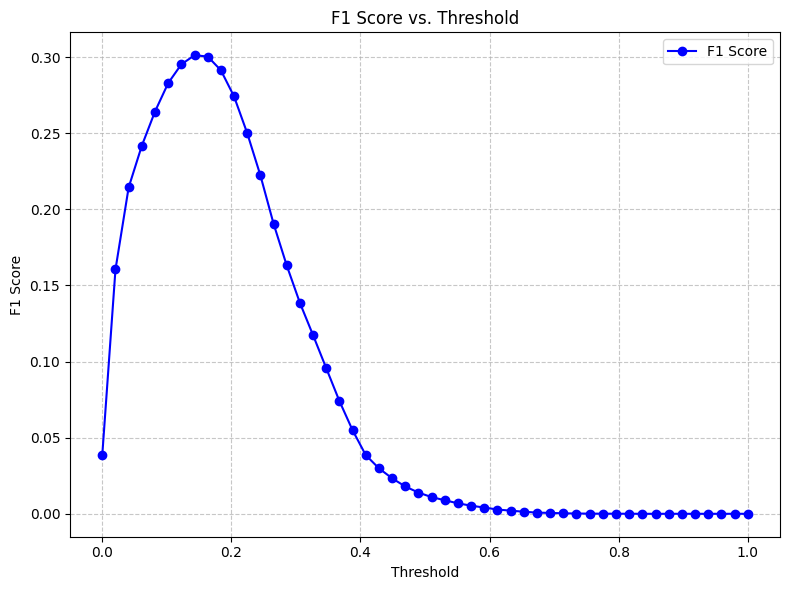

In [129]:
import numpy as np
from sklearn.metrics import f1_score

# Define a range of thresholds
thresholds = np.linspace(0, 1, 50)  # 50 thresholds between 0 and 1
f1_scores = []

# Calculate F1-score for each threshold
for threshold in thresholds:
    y_pred = (preds >= threshold).astype(int)  # Convert predictions to binary
    f1 = f1_score(y_valid, y_pred)
    f1_scores.append(f1)

# Plot F1-score vs. threshold
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores, marker='o', color='blue', label='F1 Score')
plt.title('F1 Score vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()


In [122]:
# 7. Predict
preds = gbm.predict(X_valid, num_iteration=gbm.best_iteration)

# 8. Evaluation
y_pred_label = (preds >= 0.2).astype(int)

X_valid_filtered = X_valid[['price']]
X_valid_filtered['y_pred'] = preds
X_valid_filtered['y_pred_label'] = y_pred_label
X_valid_filtered['y_valid'] = y_valid
X_valid_filtered

,price,y_pred,y_pred_label,y_valid
7521770,321.73,0.014198,0,0
7386049,421.86,0.000020,0,0
1788267,257.15,0.000086,0,0
7314904,101.89,0.000015,0,0
11144979,72.97,0.015160,0,0
...,...,...,...,...
7138967,8.49,0.000065,0,0
3413157,275.25,0.012763,0,0
11947899,128.70,0.016791,0,0
4660809,155.73,0.005307,0,0


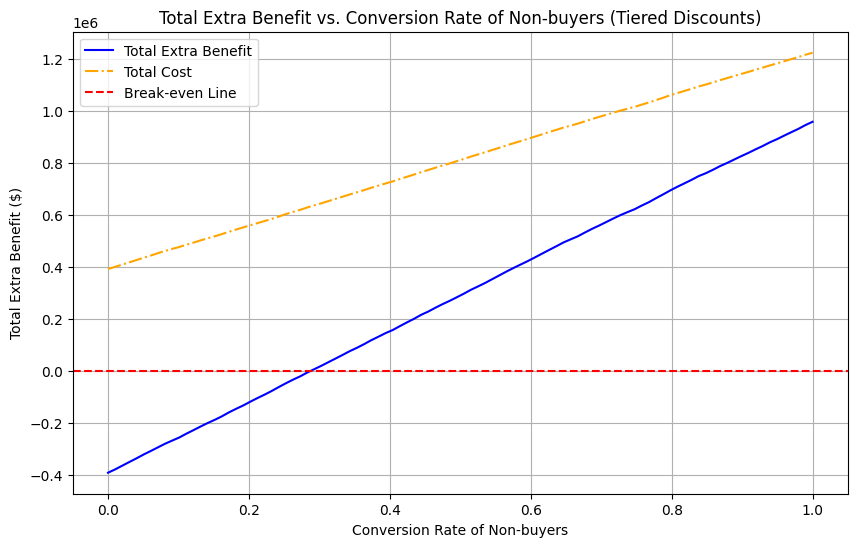

In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume df contains 'price' and 'y_valid' columns
# y_valid = 1 indicates users who would buy without a coupon
# y_valid = 0 indicates users who wouldn't buy without a coupon
# price column represents the product price

# Predicted buyers
df = X_valid_filtered[X_valid_filtered['y_pred_label'] == 1]

profit_rate = 0.20

# Calculate 25th and 75th percentiles of price
q1 = df['price'].quantile(0.25)
q3 = df['price'].quantile(0.75)

# Assign discount rates based on price range
df['discount_rate'] = np.where(
    df['price'] < q1,               0.15, 
    np.where(df['price'] <= q3,     0.10, 
                                    0.05))

# Simulate different conversion rates for non-buyers
conversion_rates = np.linspace(0, 1, 100)
total_benefits_price_strategy = []
total_costs = []

for conversion_rate in conversion_rates:
    np.random.seed(690)  

    # Simulate coupon acceptance for non-buyers
    df['accept_coupon'] = np.where((df['y_valid'] == 0) & (np.random.rand(len(df)) < conversion_rate), 1, 0)
    df['extra_benefit'] = 0.0
    df['cost'] = 0.0 

    # Users who would buy without coupons lose profit due to discounts
    df.loc[df['y_valid'] == 1, 'extra_benefit'] = -df['price'] * df['discount_rate']
    df.loc[df['y_valid'] == 1, 'cost'] = df['price'] * df['discount_rate'] 
    # Non-buyers who convert due to coupons contribute profit minus discounts
    df.loc[(df['y_valid'] == 0) & (df['accept_coupon'] == 1), 'extra_benefit'] = (df['price'] * profit_rate - df['price'] * df['discount_rate'])
    df.loc[(df['y_valid'] == 0) & (df['accept_coupon'] == 1), 'cost'] = df['price'] * df['discount_rate']
    
    # Sum total extra benefit
    total_benefits_price_strategy.append(df['extra_benefit'].sum())
    total_costs.append(df['cost'].sum())

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(conversion_rates, total_benefits_price_strategy, label="Total Extra Benefit", color='b')
plt.plot(conversion_rates, total_costs, linestyle='-.', label="Total Cost", color='orange')
plt.axhline(0, color='r', linestyle='--', label='Break-even Line')
plt.title("Total Extra Benefit vs. Conversion Rate of Non-buyers (Tiered Discounts)")
plt.xlabel("Conversion Rate of Non-buyers")
plt.ylabel("Total Extra Benefit ($)")
plt.legend()
plt.grid(True)
plt.show()


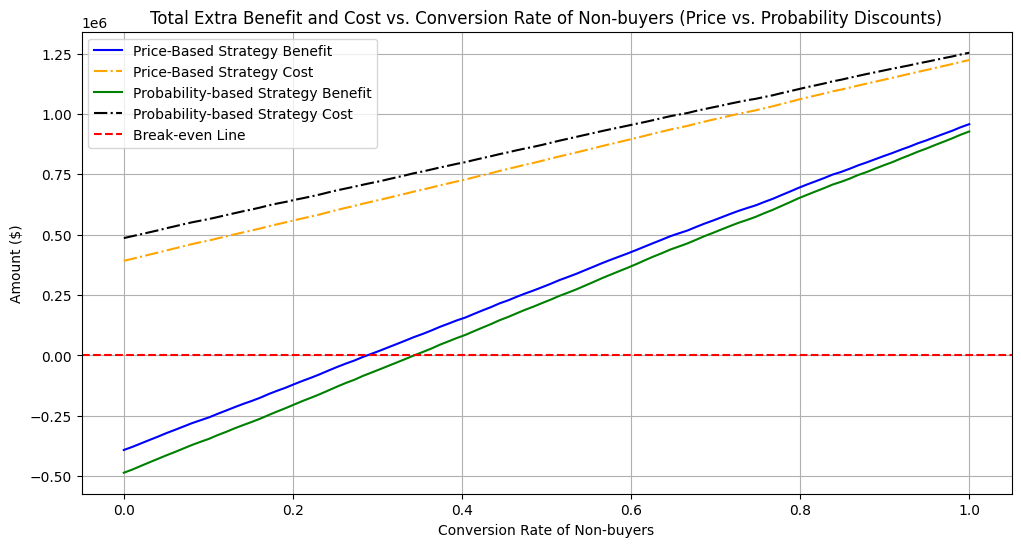

In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Original profit_rate
profit_rate = 0.20  

# Assign discount rate based on y_pred probability
df['discount_rate'] = np.where(
    df['y_pred'] <= np.percentile(df['y_pred'], 25),               0.00, 
    np.where(df['y_pred'] <= np.percentile(df['y_pred'], 50),      0.05,
    np.where(df['y_pred'] <= np.percentile(df['y_pred'], 75),      0.10,
                                                               0.15)))

# Simulate different conversion rates for non-buyers
conversion_rates = np.linspace(0, 1, 100)
total_benefits_probability_strategy = []
total_cost_probability_strategy = []

for conversion_rate in conversion_rates:
    np.random.seed(690)  

    # Simulate coupon acceptance for non-buyers
    df['accept_coupon'] = np.where((df['y_valid'] == 0) & (np.random.rand(len(df)) < conversion_rate), 1, 0)
    df['extra_benefit'] = 0.0
    df['cost'] = 0.0 

    # For buyers who would purchase without coupons, calculate profit loss due to discounts
    df.loc[df['y_valid'] == 1, 'extra_benefit'] = -df['price'] * df['discount_rate']
    df.loc[df['y_valid'] == 1, 'cost'] = df['price'] * df['discount_rate'] 
    # For non-buyers who convert due to coupons, calculate net profit (profit minus discount)
    df.loc[(df['y_valid'] == 0) & (df['accept_coupon'] == 1), 'extra_benefit'] = (df['price'] * profit_rate - df['price'] * df['discount_rate'])
    df.loc[(df['y_valid'] == 0) & (df['accept_coupon'] == 1), 'cost'] = df['price'] * df['discount_rate'] 
    # Calculate total extra benefit
    total_benefits_probability_strategy.append(df['extra_benefit'].sum())
    total_cost_probability_strategy.append(df['cost'].sum())

# Visualize the comparison
plt.figure(figsize=(12, 6))
plt.plot(conversion_rates, total_benefits_price_strategy, label="Price-Based Strategy Benefit", color='b')
plt.plot(conversion_rates, total_costs, linestyle='-.', label="Price-Based Strategy Cost", color='orange')
plt.plot(conversion_rates, total_benefits_probability_strategy, label="Probability-based Strategy Benefit", color='g')
plt.plot(conversion_rates, total_cost_probability_strategy, label="Probability-based Strategy Cost", color='black', linestyle='-.')
plt.axhline(0, color='r', linestyle='--', label='Break-even Line')
plt.title("Total Extra Benefit and Cost vs. Conversion Rate of Non-buyers (Price vs. Probability Discounts)")
plt.xlabel("Conversion Rate of Non-buyers")
plt.ylabel("Amount ($)")
plt.legend()
plt.grid(True)
plt.show()
